In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
embedding_layer = layers.Embedding(1000,5)

In [ ]:
result = embedding_layer( np.array([3, 1, 4]) )
print(result.numpy())

[[ 0.00816163  0.0288089  -0.03766399 -0.03581486  0.01124399]
 [ 0.03279256 -0.02649897  0.00642617 -0.00410575  0.03361071]
 [ 0.04128258 -0.03844526 -0.01268597 -0.019815    0.02407077]]


In [ ]:
feeding = embedding_layer(np.zeros((64,15),dtype=int))
print(feeding.numpy())

[[[ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  ...
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]]

 [[ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  ...
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]]

 [[ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  [ 0.01032776 -0.04555292 -0.02859346  0.04983025 -0.00048564]
  ...
  [ 0.01032776 -0.

## Next Word Prediction


In [ ]:
import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: 
                f.write(chunk)
    
dataset_file = '/tmp/tweets.csv'
download_file_from_google_drive('1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6', dataset_file)

import pandas as pd

tweets = pd.read_csv(dataset_file, )
tweets.head()

#data preprocessing
print('Initial amount of Tweets:',len(tweets))
tweets.drop(tweets[tweets.isRetweet == 't'].index, inplace=True)
tweets.drop(tweets[tweets.favorites < 1e4].index, inplace=True)
tweets.text = tweets.text.str.lower()
tweets.text.replace(regex=r'https?:\/\/(www\.)?[-a-z0-9@:%._\+~#=]{1,256}\.[a-z0-9()]{1,6}\b([-a-z0-9()@:%_\+.~#?&\/=]*)', value='', inplace=True)

tweets.text.replace(regex=r'#\w+', value='', inplace=True)
tweets.text.replace('&amp;', '&', inplace=True, regex=True)

tweets.drop(tweets[tweets.text.str.startswith('"""')].index, inplace=True)
tweets.drop(tweets[tweets.text.str.startswith('"via ')].index, inplace=True)
tweets.text.replace(regex=r'[^a-z0-9,. ]', value='', inplace=True)
tweets.drop(tweets[tweets.text.str.startswith('    ')].index, inplace=True)
tweets.drop(tweets[tweets.text.map(len) < 50].index, inplace=True)
print('Remaining Tweets:',len(tweets))

tweets = tweets.text.to_list()

Initial amount of Tweets: 56571
Remaining Tweets: 14688


In [ ]:
len(list(set(' '.join(tweets).split(' '))))

27253

In [ ]:
VOCABULARY_SIZE = int(1e4)

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCABULARY_SIZE,filters='!"“#$%&()*+.,-/:;=?@[]^_`{|}~ \t\n',lower=True,split=' ',oov_token="<unk>")
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

print(list(tokenizer.index_word.items())[:10])

[(1, '<unk>'), (2, 'the'), (3, 'to'), (4, 'and'), (5, 'of'), (6, 'a'), (7, 'in'), (8, 'is'), (9, 'for'), (10, 'i')]


In [ ]:
sequences =  tokenizer.texts_to_sequences(tweets)
sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post',value=0)

In [ ]:
sequence_length = sequences.shape[1]
print('Max sequence length:', sequence_length)

Max sequence length: 61


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EMBEDDING_DIM = 16

def split_input_target(sequence):
  input_sequence = sequence[:-1]
  target_sequence = sequence[1:]
  return input_sequence, target_sequence

dataset = tf.data.Dataset.from_tensor_slices(sequences)
dataset = dataset.map(split_input_target)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: ((64, 60), (64, 60)), types: (tf.int32, tf.int32)>


In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def build_model_gru(vocabulary_size, embedding_dim, batch_size, sequence_length, summary=True):
  
  inputs = layers.Input(batch_input_shape=(batch_size, sequence_length-1,))
  
  x = layers.Embedding(vocabulary_size,
                       embedding_dim)(inputs)
  x = layers.GRU(128,
                 return_sequences=True,
                 stateful=True,
                 )(x)
  x = layers.Dropout(.2)(x)
  out = layers.Dense(vocabulary_size, 
                     activation='softmax'
                     )(x)

  model = Model(inputs, out, name='next_character_prediction')
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(lr=1e-3),
                metrics='accuracy')
  
  if summary:
    print(model.summary())
  
  return model

EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                         patience=5, 
                                                         restore_best_weights=True)

In [ ]:
from matplotlib import pyplot as plt

def plot_history(history, ylim=None):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(np.array(history.epoch)+1, history.history['loss'])
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  ax1.grid(alpha=.5)
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(np.array(history.epoch)+1, history.history['accuracy'])
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.grid(alpha=.5)
  if ylim:
    ax2.set_ylim(ylim)
  plt.show() 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "next_character_prediction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 60)]                0         
_________________________________________________________________
embedding_1 (Embedding)      (64, 60, 16)              160000    
_________________________________________________________________
gru (GRU)                    (64, 60, 128)             56064     
_________________________________________________________________
dropout (Dropout)            (64, 60, 128)             0         
_________________________________________________________________
dense (Dense)                (64, 60, 10000)           1290000   
Total params: 1,506,064
Trainable params: 1,506,064
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
229/229 [==============================] - 16s 37ms/step - loss: 4.6156 - accurac

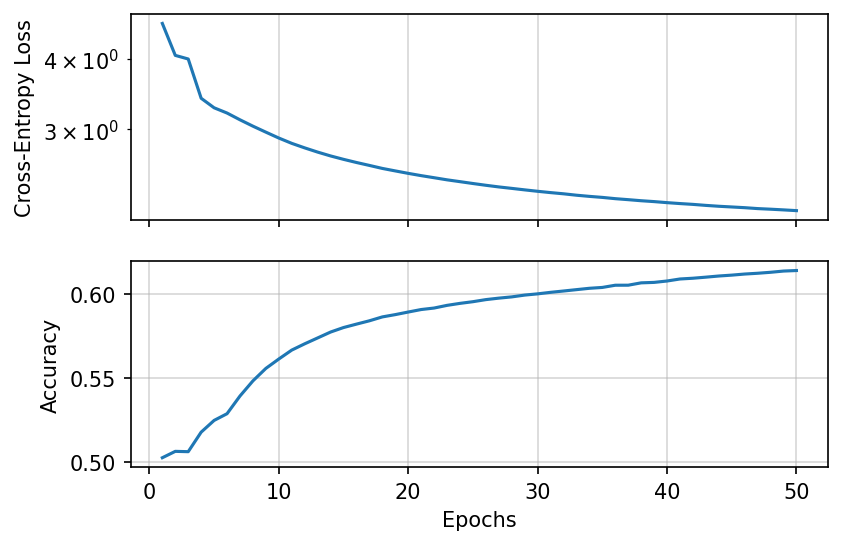

In [ ]:
gru_model = build_model_gru(VOCABULARY_SIZE, EMBEDDING_DIM, BATCH_SIZE, sequence_length)
gru_history = gru_model.fit(dataset, 
                            epochs=50,
                            callbacks=[EarlyStoppingCallback]
                            )
plot_history(gru_history)

In [ ]:
emb_matrix = gru_model.layers[1].get_weights()[0]
print(emb_matrix.shape)

(10000, 16)


In [ ]:
def get_embedding_vector( word_in, tokenizer, embedding_matrix ):
  
  assert word_in in tokenizer.word_index.keys(), 'word not in vocabulary: "{}"'.format(word_in)
  id = tokenizer.word_index[word_in]
  emb_vec = embedding_matrix[id]
  return emb_vec

In [ ]:
len(list(tokenizer.index_word.keys()))

16591

In [ ]:
get_embedding_vector('dog', tokenizer, emb_matrix)

array([-0.14371186, -0.12646656,  0.05918747, -0.08871305,  0.05486191,
       -0.04836854, -0.09572491,  0.03914633, -0.05049417,  0.12990707,
        0.15176742,  0.17400157, -0.32697052,  0.15862016,  0.2134231 ,
        0.22086574], dtype=float32)

## Word Similarity



In [ ]:
def cosine_similarity(u, v):
  cos_similarity = np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

  return cos_similarity

In [ ]:
print(cosine_similarity(get_embedding_vector( 'beautiful', tokenizer, emb_matrix ),
                        get_embedding_vector( 'wonderful', tokenizer, emb_matrix )))

print(cosine_similarity(get_embedding_vector( 'woman', tokenizer, emb_matrix ),
                        get_embedding_vector( 'man', tokenizer, emb_matrix )))

0.78959197
0.64323074


In [ ]:
def closest_word(word_in, emb_matrix, top_k=5):

  word_in_emb = get_embedding_vector(word_in, tokenizer, emb_matrix)
  similarity = [ cosine_similarity(w_emb, word_in_emb) for w_emb in emb_matrix ]
  idxs = np.argsort( similarity )[::-1][1:top_k+1]

  return [ [tokenizer.index_word[i], similarity[i]] for i in idxs ]


for word in ['beautiful', 'news']:
  print(closest_word(word, emb_matrix))

[['11th', 0.8634861], ['limit', 0.862007], ['nice', 0.85089916], ['wifes', 0.8439427], ['et', 0.8333764]]
[['306223', 0.8240227], ['qatar', 0.81878173], ['press', 0.81672484], ['complaint', 0.8080317], ['2020', 0.80415785]]


## Word Analogy


In [ ]:
def complete_analogy(word_a, word_b, word_c):

  word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()

  e_a = get_embedding_vector(word_a, tokenizer, emb_matrix)
  e_b = get_embedding_vector(word_b, tokenizer, emb_matrix)
  e_c = get_embedding_vector(word_c, tokenizer, emb_matrix)
  
  max_cosine_sim = -100
  best_word = None

  for w_idx, w in enumerate(emb_matrix):
    if (w == [e_a, e_b, e_c]).all(1).any():
      continue
    cosine_sim = cosine_similarity(e_b-e_a,w-e_c)

    if cosine_sim > max_cosine_sim:
      max_cosine_sim = cosine_sim
      best_word_idx = w_idx

      print(cosine_sim, tokenizer.index_word[best_word_idx])
      
  return tokenizer.index_word[best_word_idx]

In [ ]:
print(complete_analogy('china', 'beijing', 'usa'))

print(complete_analogy('man', 'king', 'woman'))

-0.14922173 <pad>
0.030969046 <unk>
0.08781504 the
0.2875895 to
0.41564822 of
0.46204475 in
0.57505035 for
0.5823738 protect
0.60052216 cut
0.7001197 lower
lower
-0.30983195 <pad>
0.5380452 <unk>
0.5747308 out
0.77932376 state
0.84760636 dirty
dirty


##GloVe Embedding



In [ ]:
import requests, os, zipfile
import numpy as np

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: 
                f.write(chunk)

def unzip(file, destination=None):
  if not destination or not os.path.isdir(destination):
    destination = os.path.dirname(file)
  print('unzipping to ',destination)
  zip_ref = zipfile.ZipFile(file, 'r')
  zip_ref.extractall(destination)
  zip_ref.close()


data_path = '/tmp/glove'
glove_file = os.path.join(data_path, 'glove.6B.50d.txt')
!rm -rf $data_path
os.makedirs(data_path)

download_file_from_google_drive('1JUdsQpf_-fGs8kYA4PBS1rnd0IPZYFVd', glove_file)

def read_glove_vecs(glove_file):
  with open(glove_file, 'r') as f:
    words = set()
    word_to_vec_map = {}
    
    for line in f:
      line = line.strip().split()
      curr_word = line[0]
      words.add(curr_word)
      word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
          
  return words, word_to_vec_map

In [ ]:
words, word_to_vec_map = read_glove_vecs(glove_file)

In [ ]:
print(cosine_similarity(word_to_vec_map['beautiful'],
                        word_to_vec_map['wonderful'],))

print(cosine_similarity(word_to_vec_map['dog'],
                        word_to_vec_map['cat'],))

print(cosine_similarity(word_to_vec_map['woman'],
                        word_to_vec_map['man'],))

0.8296378712614463
0.9218005273769252
0.886033771849582


In [ ]:
def complete_analogy_glove(word_a, word_b, word_c):

  word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()

  e_a = word_to_vec_map[word_a]
  e_b = word_to_vec_map[word_b]
  e_c = word_to_vec_map[word_c]
  
  words = word_to_vec_map.keys()
  max_cosine_sim = -100
  best_word = None

  for w in words:        
    if w in [word_a, word_b, word_c] :
      continue
    cosine_sim = cosine_similarity(e_b - e_a, word_to_vec_map[w] - e_c)
    
    if cosine_sim > max_cosine_sim:
      max_cosine_sim = cosine_sim
      best_word = w
      
  return best_word

In [ ]:
complete_analogy_glove('king', 'man', 'queen')

'woman'

In [ ]:
def closest_word_glove(embedding_vector, remove_words=[], top_k=5):

  vocabulary = list(word_to_vec_map.keys())

  for w in remove_words:
    vocabulary.remove(w)
  w_embeddings = np.array([word_to_vec_map[w] for w in vocabulary])
  similarity = [ cosine_similarity(w_emb, embedding_vector) for w_emb in w_embeddings ]
  idxs = np.argsort( similarity )[::-1][:top_k]

  return [ [vocabulary[i], similarity[i]] for i in idxs ]


for word in ['beautiful', 'news']:
  print(closest_word_glove(word_to_vec_map[word], [word]))

[['lovely', 0.921088084676833], ['gorgeous', 0.893486407216522], ['wonderful', 0.8296378712614463], ['charming', 0.8249218663752111], ['beauty', 0.8014683990617305]]
[['press', 0.8883447788255655], ['interview', 0.849574463576904], ['newspaper', 0.8341822594978636], ['newspapers', 0.828009445659333], ['reported', 0.8237055907435875]]
